In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import scipy.optimize
import scipy.sparse
import cvxpy as cp
import relplot as rp
import math

In [15]:
def prepare_dataset(n, skew_function, e):
    res = []
    fa = []
    ya = []
    for _ in range(n):
        f = np.random.uniform(0,1-e)
        y = int(np.random.uniform() > 1 - skew_function(f))
        fa.append(f)
        ya.append(y)
    return (np.array(fa), np.array(ya))

In [17]:
def smCE_LP(S):
    (x_list, y_list) = S
    indices = np.argsort(x_list)
    x_list = x_list[indices]
    y_list = y_list[indices]
    A = np.diag([1]*len(x_list))
    A = (A -np.roll(A, 1, axis = 1))[0:len(x_list)-1]
    A = np.concatenate([A, -A])
    b = (x_list- np.roll(x_list,1,axis=0))[1:len(x_list)]
    b = np.concatenate([b,b])
    c = y_list - x_list
    return c, A, b

In [18]:
def smCE_uc(S):
    (x_list, y_list) = S
    n = len(x_list)
    indices = np.argsort(x_list)
    x_list = x_list[indices]
    y_list = y_list[indices]
    A = np.diag([1]*len(x_list))
    A = (A -np.roll(A, 1, axis = 1))[0:len(x_list)-1]
    temp = np.concatenate([A, -A])
    counter = temp.shape[0]
    A = np.zeros((counter+ 2*2**int(np.log(n)/np.log(2))-2, n))
    A[0:counter] = temp
    k = int(np.log2(n-1))
    for i in range(1, k+1):
        for j in range(1, 2**(k - i)+1):
            A[counter][(j-1)*2**i] = 1
            A[counter][j*2**i] = -1

            A[counter+1][(j-1)*2**i] = -1         
            A[counter+1][j*2**i] = 1
            counter +=2
    b = np.abs(A@x_list)
    c = y_list - x_list
    return c, A, b



In [19]:
# c, A, b = smCE_LP(S_calibrated)
# n = len(S_calibrated[0])
# x = cp.Variable(n)
# objective = cp.Minimize(np.array([c/n]) @ x)
# constraints = [-1 <= x, x <= 1, A@x <= b]
# prob = cp.Problem(objective, constraints)
# result = prob.solve()
# print(-result)

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
for i in range(5,12):
    for eps in [0.1,0.07,0.05,0.03,0.01, 0.007, 0.005,0.003, 0.001]:
        counter = 0
        for _ in range(100):
            S_calibrated = prepare_dataset(2**i+1, lambda x:x+0.01, 0.01)
            c,A,b = smCE_uc(S_calibrated)
            n = len(S_calibrated[0])
            x = cp.Variable(n)
            objective = cp.Minimize(np.array([c/n]) @ x +2*math.log(n)*cp.norm(cp.maximum(A @ x-b, np.zeros(len(A)) ),"inf"))
            constraints = [-1 <= x, x <= 1]
            prob = cp.Problem(objective, constraints)
            result = -prob.solve()
            if result >= eps/2:
                counter+=1
            if counter>50:
                break
        if counter > 50:
            print(i)
            print(counter)
            print(eps)
            break


5
51
0.1
6
51
0.07
7
51
0.05
8
51
0.03
9
51
0.03
10
51
0.01
11
51
0.01


In [22]:
for i in range(5,12):
    for eps in [0.1,0.07,0.05,0.03,0.01, 0.007, 0.005,0.003, 0.001]:
        counter = 0
        for _ in range(100):
            S_calibrated = prepare_dataset(2**i+1, lambda x:x+0.01,0.01)
            result = rp.smECE(S_calibrated[0],S_calibrated[1]) 
            if result >= eps/2:
                counter+=1
            if counter>50:
                break
        if counter > 50:
            print(i)
            print(counter)
            print(eps)
            break

5
51
0.1
6
51
0.1
7
51
0.1
8
51
0.07
9
51
0.07
10
51
0.05
11
51
0.03


In [23]:
def LDTC(S, eps):
    (x_list, y_list) = S
    n = len(x_list)
    U = np.array(range(int(1/eps)))*eps
    u = len(U)
    A_1 = np.zeros((n*2,n*2*u))
    A_2 = np.zeros((u,n*2*u))
    for i in range(2*n):
        for j in range(u):
            A_1[i][j*2*n+i] = 1
    for i in range(u):
        A_2[i][2*i*n: (2*i+1)*n] = [-U[i]]*n
        A_2[i][(2*i+1)*n: (2*i+2)*n] = [1-U[i]]*n 

    b_1 = np.zeros(2*n)
    for i in range(n):
        if y_list[i] == 0:
            b_1[i] = 1/n
        else:
            b_1[i+n] = 1/n 
    b_2 = np.zeros(u)
    c = np.zeros(u*n*2)
    for i in range(u):
        for j in range(n):
            c[2*n*i+j] = U[i]- x_list[j]
            c[2*n*i+j+n] = U[i]- x_list[j]
    c = np.abs(c)
    return A_1, A_2, b_1, b_2, c

In [27]:
for i in range(5,9):
    for eps in [0.1,0.07,0.05,0.03,0.01, 0.007, 0.005,0.003, 0.001]:
        counter = 0
        for _ in range(100):
            S_calibrated = prepare_dataset(2**i+1, lambda x:x+0.01,0.01)
            n = len(S_calibrated[0])
            A_1, A_2, b_1, b_2, c = LDTC(S_calibrated, eps)
            x = cp.Variable(n*2*int(1/eps))
            objective = cp.Minimize(c @ x+ 4*cp.norm(A_1 @ x-b_1 ,1) + 4*cp.norm(A_2 @ x ,1))
            constraints = [0 <= x]
            prob = cp.Problem(objective, constraints)
            result = prob.solve()
            if result >= eps:
                counter+=1
            if counter>50:
                break
        if counter > 50:
            print(i)
            print(counter)
            print(eps)
            break





5
51
0.05
6
51
0.03
7
51
0.01
8
51
0.01


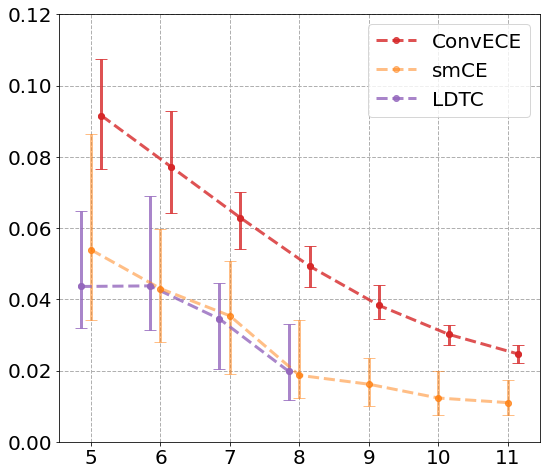

In [35]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

t = np.array([0,1,2,4,9,19,199])
# Ens number are 2, 4, 8, 16


smCE = np.array([0.05392731, 0.04302569, 0.03538085, 0.01867338, 0.01617483, 0.01229978,0.01100074])
smECE =  np.array([0.09160847,0.07728072, 0.06293585, 0.04930626, 0.0382798,  0.03017715, 0.02466714])
ldtc = np.array([0.04362023, 0.04378679,0.03450147, 0.01974462])


plt.rcParams['font.size']=20
plt.rcParams['legend.fontsize']=20
fig, ax1 = plt.subplots(figsize=(8,7))

# color_r = 'tab:red'
color = 'tab:blue'
width = 0.25


ax1.set_xticks(np.arange(0,7)i)
ax1.set_xticklabels(["5", "6", "7", "8", '9', '10', '11'], rotation=0)
ax1.tick_params(axis='y')#, labelcolor=color)
ax1.set_ylim((19.,46.))

e_smCE = np.array([smCE - [0.03429807, 0.02803707, 0.01909696, 0.01220246, 0.00991716, 0.00745008, 0.00738633], 
                   [0.08650733, 0.05965444, 0.05081143, 0.03422777, 0.02340507, 0.01989094, 0.01743458]- smCE] )
e_smECE = np.array([smECE- [0.076571, 0.06414214, 0.05409286, 0.04346742, 0.0344362,  0.02713203, 0.02218031], 
                   [0.1075522, 0.09303256, 0.07001377, 0.05500064, 0.04409024, 0.03290695, 0.02731003]-smECE] ) 
e_ldtc = np.array([ldtc-[0.03187139, 0.0313958, 0.02055663, 0.01184783], 
                   [0.06479745,0.06912442, 0.0445265, 0.03299556]-ldtc])

color_r = 'tab:red'
color_o = 'tab:orange'
color_p = 'tab:purple'


n_1, = ax1.plot(np.arange(0,4)-0.15, ldtc, 'o--', color=color_p, alpha = 0.8, label='LDTC', linewidth=3)
plt.errorbar(np.arange(0,4)-0.15, ldtc, e_ldtc, fmt='o', color=color_p, alpha = 0.8,  capsize=6, linewidth=3)

n_2, = ax1.plot(np.arange(0,7), smCE, 'o--', color=color_o, alpha = 0.5, label='smCE', linewidth=3)
plt.errorbar(np.arange(0,7), smCE, e_smCE, fmt='o', color=color_o,alpha = 0.5,  capsize=6, linewidth=3)

n_3, = ax1.plot(np.arange(0,7)+0.15, smECE, 'o--', color=color_r, alpha = 0.8,label='ConvECE', linewidth=3)
plt.errorbar(np.arange(0,7)+0.15, smECE, e_smECE, fmt='o', color=color_r,alpha = 0.8, capsize=6, linewidth=3)


ax1.tick_params(axis='y')#, labelcolor=color_r)
ax1.set_ylim((0, 0.12))
ax1.legend([(n_3), (n_2), (n_1)], ['ConvECE', 'smCE', 'LDTC'], numpoints=1,
          handler_map={tuple:HandlerTuple(ndivide=None)}, loc=1,  bbox_to_anchor=(1, 1))

ax1.grid(linestyle='--', linewidth=1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()


